In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-11-28 09:05:12.019790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [220]:
# https://finance.yahoo.com/quote/TSLA/history?period1=1290643200&period2=1669334400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = pd.read_csv("./stock/TSLA_2010-2022.csv")
df
# Date : 날짜
# open : 시가
# High : 상한가
# Low : 하한가
# Close : 종가
# Adj Close : 종가
# Volume : 거래량

# 전날 데이터를 가지고 다음날 데이터를 알 수 있다. 

Date        Open        High         Low       Close   Adj Close  \
0     2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
1     2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2     2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
3     2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
4     2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
...          ...         ...         ...         ...         ...         ...   
3119  2022-11-17  183.960007  186.160004  180.899994  183.169998  183.169998   
3120  2022-11-18  185.050003  185.190002  176.550003  180.190002  180.190002   
3121  2022-11-21  175.850006  176.770004  167.539993  167.869995  167.869995   
3122  2022-11-22  168.630005  170.919998  166.190002  169.910004  169.910004   
3123  2022-11-23  173.570007  183.619995  172.500000  183.199997  183.199997   

         Volume  
0     257806500  
1     123282000  
2      77097000  
3     103003500  
4     103825500  
...         ...  
3119   64336000  
3120   75904900  
3121   92882700  
3122   78452300  
3123  109536700  

[3124 rows x 7 columns]

# 전처리

In [221]:
# 시계열 인덱스를 따로 만들어야 한다.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2022-11-10', '2022-11-11', '2022-11-14', '2022-11-15',
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23'],
              dtype='datetime64[ns]', name='Date', length=3124, freq=None)

In [185]:
# 데이터의량이 많이 때문에 작은 데이터부터 관리

# 날짜가 확인 가능하다.
df['2019-01']

/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/1349837109.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2019-01']


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-02  20.406668  21.008667  19.920000  20.674667  20.674667  174879000
2019-01-03  20.466667  20.626667  19.825333  20.024000  20.024000  104478000
2019-01-04  20.400000  21.200001  20.181999  21.179333  21.179333  110911500
2019-01-07  21.448000  22.449333  21.183332  22.330667  22.330667  113268000
2019-01-08  22.797333  22.934000  21.801332  22.356667  22.356667  105127500
2019-01-09  22.366667  22.900000  22.098000  22.568666  22.568666   81493500
2019-01-10  22.293333  23.025999  22.119333  22.997999  22.997999   90846000
2019-01-11  22.806000  23.227333  22.584667  23.150667  23.150667   75586500
2019-01-14  22.825333  22.833332  22.266666  22.293333  22.293333   78709500
2019-01-15  22.333332  23.253332  22.299999  22.962000  22.962000   90849000
2019-01-16  22.985332  23.466667  22.900000  23.070000  23.070000   70375500
2019-01-17  23.080667  23.433332  22.943333  23.153999  23.153999   55150500
2019-01-18  21.533333  21.808666  19.982000  20.150667  20.150667  362262000
2019-01-22  20.321333  20.533333  19.700001  19.927999  19.927999  181000500
2019-01-23  19.500000  19.633333  18.779333  19.172667  19.172667  187950000
2019-01-24  18.868668  19.578667  18.618668  19.434000  19.434000  120183000
2019-01-25  19.625999  19.901333  19.303333  19.802668  19.802668  108744000
2019-01-28  19.527332  19.830667  19.183332  19.758667  19.758667   96349500
2019-01-29  19.684668  19.903999  19.453333  19.830667  19.830667   69325500
2019-01-30  20.030001  20.600000  19.899332  20.584667  20.584667  168754500
2019-01-31  20.066668  20.770666  19.600000  20.468000  20.468000  188538000

In [222]:
# 2019년 2월의 Adj Close 데이터를 가져온다.
df201901 = df['2019-01']
df201901 = df201901.iloc[:, -2]
df201901

/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/897580893.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df201901 = df['2019-01']


Date
2019-01-02    20.674667
2019-01-03    20.024000
2019-01-04    21.179333
2019-01-07    22.330667
2019-01-08    22.356667
2019-01-09    22.568666
2019-01-10    22.997999
2019-01-11    23.150667
2019-01-14    22.293333
2019-01-15    22.962000
2019-01-16    23.070000
2019-01-17    23.153999
2019-01-18    20.150667
2019-01-22    19.927999
2019-01-23    19.172667
2019-01-24    19.434000
2019-01-25    19.802668
2019-01-28    19.758667
2019-01-29    19.830667
2019-01-30    20.584667
2019-01-31    20.468000
Name: Adj Close, dtype: float64

# 시각화

<AxesSubplot:xlabel='Date'>

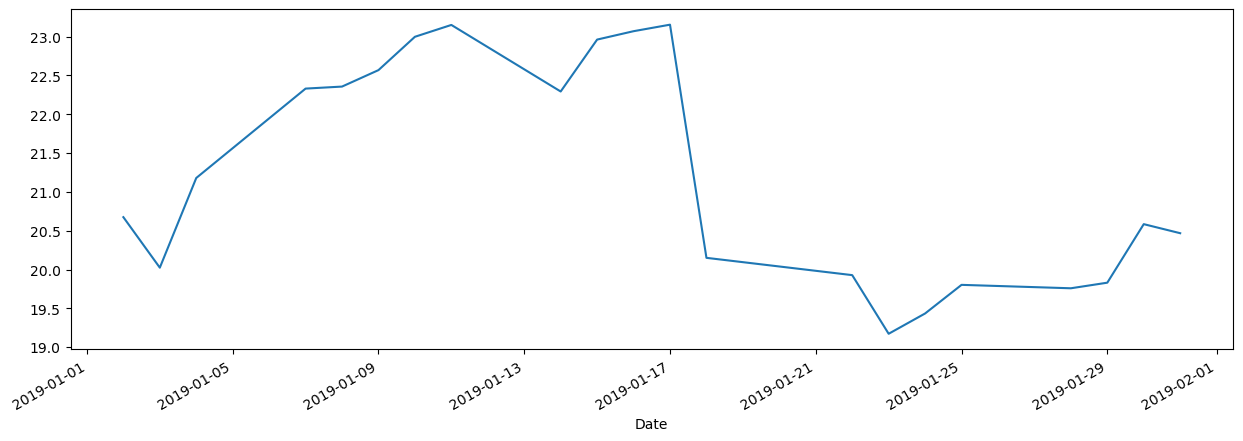

In [187]:
fig, ax = plt.subplots(figsize=(15, 5))
df201901.plot(ax=ax)

# 데이터 분리

In [223]:
df_len = len(df201901)
df_len
# 데이터 프레임을 데이터의 최대 개수로 맞추고 빈자리에 0을 대입한다.

21

In [224]:
from sklearn.model_selection import TimeSeriesSplit

In [344]:
# n_splits : 출력할 전체 개수
# max_train_size : Xtrain 데이터의 최대 개수
# test_size : 결과수, ytest
mts = 20
tss = TimeSeriesSplit(n_splits=df_len-1, max_train_size=mts, test_size=1)

for trn, val in tss.split(df201901):
    print(trn, val)

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]
[0 1 2 3 4 5 6 7 8 9] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20]


In [146]:
mts = df_len-1
ts = 3
tss = TimeSeriesSplit(n_splits=int(len(df201901)/ts)-1, max_train_size=mts, test_size=ts)
for idx, (trn, val) in enumerate(tss.split(df201901)):
    print(idx, trn, val)

0 [0 1 2] [3 4 5]
1 [0 1 2 3 4 5] [6 7 8]
2 [0 1 2 3 4 5 6 7 8] [ 9 10 11]
3 [ 0  1  2  3  4  5  6  7  8  9 10 11] [12 13 14]
4 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15 16 17]
5 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20]


In [226]:
# val의 인덱스로 데이터 프레임을 만들고 0으로 채운다. 

ndf = np.zeros([val[0], int(df_len)])
ndf = pd.DataFrame(ndf)
ndf

0    1    2    3    4    5    6    7    8    9   ...   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

     15   16   17   18   19   20  
0   0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  
4   0.0  0.0  0.0  0.0  0.0  0.0  
5   0.0  0.0  0.0  0.0  0.0  0.0  
6   0.0  0.0  0.0  0.0  0.0  0.0  
7   0.0  0.0  0.0  0.0  0.0  0.0  
8   0.0  0.0  0.0  0.0  0.0  0.0  
9   0.0  0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  0.0  
11  0.0  0.0  0.0  0.0  0.0  0.0  
12  0.0  0.0  0.0  0.0  0.0  0.0  
13  0.0  0.0  0.0  0.0  0.0  0.0  
14  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  0.0  
16  0.0  0.0  0.0  0.0  0.0  0.0  
17  0.0  0.0  0.0  0.0  0.0  0.0  
18  0.0  0.0  0.0  0.0  0.0  0.0  
19  0.0  0.0  0.0  0.0  0.0  0.0  

[20 rows x 21 columns]

## 시계열 데이터 프레임 생성
~마지막 전번 컬럼 : train <br>
마지막 컬럼 : val


In [227]:
s = 0
for i in range(val[0]-1, -1, -1):
    for y in range(s, df_len):
        ndf.iloc[i, [y]] = df201902.iloc[y-s]
    s+=1
    
ndf

0          1          2          3          4          5   \
0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
6    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
8    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
12   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
13   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
14   0.000000   0.000000   0.000000   0.000000   0.000000  20.674667   
15   0.000000   0.000000   0.000000   0.000000  20.674667  20.024000   
16   0.000000   0.000000   0.000000  20.674667  20.024000  21.179333   
17   0.000000   0.000000  20.674667  20.024000  21.179333  22.330667   
18   0.000000  20.674667  20.024000  21.179333  22.330667  22.356667   
19  20.674667  20.024000  21.179333  22.330667  22.356667  22.568666   

           6          7          8          9   ...         11         12  \
0    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
1    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
2    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
5    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
6    0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
7    0.000000   0.000000   0.000000   0.000000  ...   0.000000  20.674667   
8    0.000000   0.000000   0.000000   0.000000  ...  20.674667  20.024000   
9    0.000000   0.000000   0.000000   0.000000  ...  20.024000  21.179333   
10   0.000000   0.000000   0.000000  20.674667  ...  21.179333  22.330667   
11   0.000000   0.000000  20.674667  20.024000  ...  22.330667  22.356667   
12   0.000000  20.674667  20.024000  21.179333  ...  22.356667  22.568666   
13  20.674667  20.024000  21.179333  22.330667  ...  22.568666  22.997999   
14  20.024000  21.179333  22.330667  22.356667  ...  22.997999  23.150667   
15  21.179333  22.330667  22.356667  22.568666  ...  23.150667  22.293333   
16  22.330667  22.356667  22.568666  22.997999  ...  22.293333  22.962000   
17  22.356667  22.568666  22.997999  23.150667  ...  22.962000  23.070000   
18  22.568666  22.997999  23.150667  22.293333  ...  23.070000  23.153999   
19  22.997999  23.150667  22.293333  22.962000  ...  23.153999  20.150667   

           13         14         15         16         17         18  \
0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1    0.000000   0.000000   0.000000   0.000000   0.000000  20.674667   
2    0.000000   0.000000   0.000000   0.000000  20.674667  20.024000   
3    0.000000   0.000000   0.000000  20.674667  20.024000  21.179333   
4    0.000000   0.000000  20.674667  20.024000  21.179333  22.330667   
5    0.000000  20.674667  20.024000  21.179333  22.330667  22.356667   
6   20.674667  20.024000  21.179333  22.330667  22.356667  22.568666   
7   20.024000  21.179333  22.330667  22.356667  22.568666  22.997999   
8   21.179333  22.330667  22.356667  22.568666  22.997999  23.150667   
9   22.330667  22.356667  22.568666  22.997999  23.150667  22.293333   
10  22.356667  22.568666  22.997999  23.150667  22.293333  22.962000   
11  22.568666  2

#### 1D Convolutions and recurrent  layers use(batch_size, sequence_length, features)
<br>

1번 모델 : 2개의 히든 레이어, 각 8개씩 노드 구성 최종 1개 결과 예측 <br>
2번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (2 filter, 3 size) <br>
3번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (10 filter, 10 size) <br>

In [340]:
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values

X.shape

(20, 20)

# DL 모델 추가

#### 1번 모델 생성

In [345]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = keras.layers.Dense(8, activation="relu")(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model = keras.Model(inputs, output)
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model.summary()



# model1 = Sequential()
# model1.add(Dense(8, input_shape = X.shape[0], activation='relu'))
# model1.add(Dense(8, activation='relu'))
# model1.add(Dense(1))

# model1.compile(loss='mse', optimizer='adam')
# model1.fit(X, y, epochs=1000)
# model1.evaluate(X, y)
# model1.predict(X)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 dense_130 (Dense)           (None, None, 8)           168       
                                                                 
 dense_131 (Dense)           (None, None, 8)           72        
                                                                 
 dense_132 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


#### 2번 모델 생성
2번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (2 filter, 3 size) <br>

In [347]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same', activation='relu')(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model2 = keras.Model(inputs, output)
full_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model2.summary()


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 conv1d_32 (Conv1D)          (None, None, 2)           122       
                                                                 
 dense_136 (Dense)           (None, None, 8)           24        
                                                                 
 dense_137 (Dense)           (None, None, 8)           72        
                                                                 
 dense_138 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________


#### 3번 모델 생성
3번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (10 filter, 10 size) <br>

In [348]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = tf.keras.layers.Conv1D(filters=10, kernel_size=10, padding='same', activation='relu')(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model3 = keras.Model(inputs, output)
full_model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model3.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 conv1d_33 (Conv1D)          (None, None, 10)          2010      
                                                                 
 dense_139 (Dense)           (None, None, 8)           88        
                                                                 
 dense_140 (Dense)           (None, None, 8)           72        
                                                                 
 dense_141 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 2,179
Trainable params: 2,179
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [341]:
Xtrn = X.reshape(-1, 1, X.shape[1])

In [349]:
hist1 = full_model.fit(X, y, epochs=1000, batch_size=1)
hist2 = full_model2.fit(Xtrn, y, epochs=1000, batch_size=1)
hist3 = full_model3.fit(Xtrn, y, epochs=1000, batch_size=1)

Epoch 1/1000
20/20 [==============================] - 0s 1ms/step - loss: 336.8452
Epoch 2/1000
20/20 [==============================] - 0s 1ms/step - loss: 151.7113
Epoch 3/1000
20/20 [==============================] - 0s 1ms/step - loss: 87.8030
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 53.2605
Epoch 5/1000
20/20 [==============================] - 0s 1ms/step - loss: 34.0364
Epoch 6/1000
20/20 [==============================] - 0s 1ms/step - loss: 21.8253
Epoch 7/1000
20/20 [==============================] - 0s 1ms/step - loss: 17.3184
Epoch 8/1000
20/20 [==============================] - 0s 1ms/step - loss: 15.5392
Epoch 9/1000
20/20 [==============================] - 0s 1ms/step - loss: 12.2042
Epoch 10/1000
20/20 [==============================] - 0s 1ms/step - loss: 11.2669
Epoch 11/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.7456
Epoch 12/1000
20/20 [==============================] - 0s 1ms/step - loss: 8.4446
Epoch 13/1000

20/20 [==============================] - 0s 1ms/step - loss: 0.0434
Epoch 94/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 95/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0756
Epoch 96/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 97/1000
20/20 [==============================] - 0s 983us/step - loss: 0.0379
Epoch 98/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0783
Epoch 99/1000
20/20 [==============================] - 0s 981us/step - loss: 0.3348
Epoch 100/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4199
Epoch 101/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1169
Epoch 102/1000
20/20 [==============================] - 0s 999us/step - loss: 0.1973
Epoch 103/1000
20/20 [==============================] - 0s 996us/step - loss: 0.2022
Epoch 104/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1050
Epoch 105/1000
20

20/20 [==============================] - 0s 964us/step - loss: 0.0046
Epoch 191/1000
20/20 [==============================] - 0s 954us/step - loss: 0.0018
Epoch 192/1000
20/20 [==============================] - 0s 977us/step - loss: 0.0029
Epoch 193/1000
20/20 [==============================] - 0s 939us/step - loss: 0.0041
Epoch 194/1000
20/20 [==============================] - 0s 952us/step - loss: 0.0022
Epoch 195/1000
20/20 [==============================] - 0s 976us/step - loss: 0.0027
Epoch 196/1000
20/20 [==============================] - 0s 955us/step - loss: 0.0027
Epoch 197/1000
20/20 [==============================] - 0s 995us/step - loss: 0.0026
Epoch 198/1000
20/20 [==============================] - 0s 970us/step - loss: 0.0062
Epoch 199/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 200/1000
20/20 [==============================] - 0s 995us/step - loss: 0.0092
Epoch 201/1000
20/20 [==============================] - 0s 941us/step - loss: 0.02

Epoch 287/1000
20/20 [==============================] - 0s 936us/step - loss: 7.1678e-04
Epoch 288/1000
20/20 [==============================] - 0s 931us/step - loss: 8.9819e-04
Epoch 289/1000
20/20 [==============================] - 0s 936us/step - loss: 5.6610e-04
Epoch 290/1000
20/20 [==============================] - 0s 952us/step - loss: 0.0011
Epoch 291/1000
20/20 [==============================] - 0s 959us/step - loss: 7.0070e-04
Epoch 292/1000
20/20 [==============================] - 0s 951us/step - loss: 8.1574e-04
Epoch 293/1000
20/20 [==============================] - 0s 949us/step - loss: 8.5739e-04
Epoch 294/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.0668e-04
Epoch 295/1000
20/20 [==============================] - 0s 955us/step - loss: 2.4567e-04
Epoch 296/1000
20/20 [==============================] - 0s 978us/step - loss: 5.3576e-04
Epoch 297/1000
20/20 [==============================] - 0s 953us/step - loss: 2.0656e-04
Epoch 298/1000
20/20 [=====

20/20 [==============================] - 0s 931us/step - loss: 0.3351
Epoch 383/1000
20/20 [==============================] - 0s 926us/step - loss: 0.2166
Epoch 384/1000
20/20 [==============================] - 0s 953us/step - loss: 0.2448
Epoch 385/1000
20/20 [==============================] - 0s 963us/step - loss: 0.2385
Epoch 386/1000
20/20 [==============================] - 0s 954us/step - loss: 0.3305
Epoch 387/1000
20/20 [==============================] - 0s 950us/step - loss: 0.0725
Epoch 388/1000
20/20 [==============================] - 0s 900us/step - loss: 0.1811
Epoch 389/1000
20/20 [==============================] - 0s 951us/step - loss: 0.2122
Epoch 390/1000
20/20 [==============================] - 0s 971us/step - loss: 0.1188
Epoch 391/1000
20/20 [==============================] - 0s 938us/step - loss: 0.2115
Epoch 392/1000
20/20 [==============================] - 0s 932us/step - loss: 0.1735
Epoch 393/1000
20/20 [==============================] - 0s 956us/step - loss: 0.

20/20 [==============================] - 0s 1ms/step - loss: 2.2307
Epoch 479/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5146
Epoch 480/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3508
Epoch 481/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5088
Epoch 482/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5284
Epoch 483/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.3136
Epoch 484/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0142
Epoch 485/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0137
Epoch 486/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4113
Epoch 487/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0532
Epoch 488/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5555
Epoch 489/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4285
Epoch 490/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.2222
Epoch 577/1000
20/20 [==============================] - 0s 980us/step - loss: 0.5048
Epoch 578/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2792
Epoch 579/1000
20/20 [==============================] - 0s 972us/step - loss: 0.1476
Epoch 580/1000
20/20 [==============================] - 0s 963us/step - loss: 0.1072
Epoch 581/1000
20/20 [==============================] - 0s 968us/step - loss: 0.2211
Epoch 582/1000
20/20 [==============================] - 0s 936us/step - loss: 0.3920
Epoch 583/1000
20/20 [==============================] - 0s 941us/step - loss: 0.4917
Epoch 584/1000
20/20 [==============================] - 0s 946us/step - loss: 0.6329
Epoch 585/1000
20/20 [==============================] - 0s 986us/step - loss: 0.2582
Epoch 586/1000
20/20 [==============================] - 0s 961us/step - loss: 0.1927
Epoch 587/1000
20/20 [==============================] - 0s 955us/step - loss: 0.4283

20/20 [==============================] - 0s 1ms/step - loss: 0.0519
Epoch 673/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2127
Epoch 674/1000
20/20 [==============================] - 0s 974us/step - loss: 0.2251
Epoch 675/1000
20/20 [==============================] - 0s 974us/step - loss: 0.7707
Epoch 676/1000
20/20 [==============================] - 0s 953us/step - loss: 1.6132
Epoch 677/1000
20/20 [==============================] - 0s 968us/step - loss: 0.8574
Epoch 678/1000
20/20 [==============================] - 0s 954us/step - loss: 1.9359
Epoch 679/1000
20/20 [==============================] - 0s 958us/step - loss: 1.2533
Epoch 680/1000
20/20 [==============================] - 0s 952us/step - loss: 0.4596
Epoch 681/1000
20/20 [==============================] - 0s 949us/step - loss: 0.2070
Epoch 682/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 683/1000
20/20 [==============================] - 0s 980us/step - loss: 0.0448
E

Epoch 769/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 770/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1003
Epoch 771/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2277
Epoch 772/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3371
Epoch 773/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3665
Epoch 774/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4634
Epoch 775/1000
20/20 [==============================] - 0s 985us/step - loss: 0.1039
Epoch 776/1000
20/20 [==============================] - 0s 954us/step - loss: 0.0943
Epoch 777/1000
20/20 [==============================] - 0s 965us/step - loss: 0.0282
Epoch 778/1000
20/20 [==============================] - 0s 978us/step - loss: 0.0398
Epoch 779/1000
20/20 [==============================] - 0s 945us/step - loss: 0.1186
Epoch 780/1000
20/20 [==============================] - 0s 970us/step - loss:

20/20 [==============================] - 0s 962us/step - loss: 0.3944
Epoch 866/1000
20/20 [==============================] - 0s 982us/step - loss: 0.1495
Epoch 867/1000
20/20 [==============================] - 0s 967us/step - loss: 0.3037
Epoch 868/1000
20/20 [==============================] - 0s 971us/step - loss: 0.1701
Epoch 869/1000
20/20 [==============================] - 0s 962us/step - loss: 0.1549
Epoch 870/1000
20/20 [==============================] - 0s 1000us/step - loss: 0.1280
Epoch 871/1000
20/20 [==============================] - 0s 965us/step - loss: 0.1229
Epoch 872/1000
20/20 [==============================] - 0s 958us/step - loss: 0.0784
Epoch 873/1000
20/20 [==============================] - 0s 992us/step - loss: 0.0345
Epoch 874/1000
20/20 [==============================] - 0s 955us/step - loss: 0.0167
Epoch 875/1000
20/20 [==============================] - 0s 969us/step - loss: 0.0156
Epoch 876/1000
20/20 [==============================] - 0s 970us/step - loss: 0

20/20 [==============================] - 0s 965us/step - loss: 0.0054
Epoch 963/1000
20/20 [==============================] - 0s 985us/step - loss: 0.0040
Epoch 964/1000
20/20 [==============================] - 0s 988us/step - loss: 0.0021
Epoch 965/1000
20/20 [==============================] - 0s 978us/step - loss: 0.0013
Epoch 966/1000
20/20 [==============================] - 0s 962us/step - loss: 6.9114e-04
Epoch 967/1000
20/20 [==============================] - 0s 1ms/step - loss: 6.5497e-04
Epoch 968/1000
20/20 [==============================] - 0s 992us/step - loss: 0.0013
Epoch 969/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 970/1000
20/20 [==============================] - 0s 990us/step - loss: 0.0014
Epoch 971/1000
20/20 [==============================] - 0s 984us/step - loss: 0.0011
Epoch 972/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 973/1000
20/20 [==============================] - 0s 966us/step - loss: 

20/20 [==============================] - 0s 1ms/step - loss: 2.1173
Epoch 61/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1011
Epoch 62/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1125
Epoch 63/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2221
Epoch 64/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2924
Epoch 65/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2392
Epoch 66/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2276
Epoch 67/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1655
Epoch 68/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4102
Epoch 69/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1664
Epoch 70/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2667
Epoch 71/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4064
Epoch 72/1000
20/20 [=========

20/20 [==============================] - 0s 1ms/step - loss: 2.1405
Epoch 160/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1116
Epoch 161/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1379
Epoch 162/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1408
Epoch 163/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4696
Epoch 164/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5277
Epoch 165/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2050
Epoch 166/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2508
Epoch 167/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1480
Epoch 168/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4849
Epoch 169/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0890
Epoch 170/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2778
Epoch 171/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.2258
Epoch 258/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2047
Epoch 259/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2239
Epoch 260/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2561
Epoch 261/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0854
Epoch 262/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1597
Epoch 263/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1607
Epoch 264/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2284
Epoch 265/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2592
Epoch 266/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2778
Epoch 267/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.9743
Epoch 268/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4632
Epoch 269/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.7586
Epoch 356/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4181
Epoch 357/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3139
Epoch 358/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4737
Epoch 359/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3112
Epoch 360/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4587
Epoch 361/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0972
Epoch 362/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1933
Epoch 363/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5082
Epoch 364/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1670
Epoch 365/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1545
Epoch 366/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3600
Epoch 367/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.2025
Epoch 454/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.3313
Epoch 455/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4067
Epoch 456/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1483
Epoch 457/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1803
Epoch 458/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3785
Epoch 459/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4900
Epoch 460/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3442
Epoch 461/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1525
Epoch 462/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2263
Epoch 463/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1734
Epoch 464/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1856
Epoch 465/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.2313
Epoch 552/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2978
Epoch 553/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5514
Epoch 554/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.6775
Epoch 555/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2896
Epoch 556/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2514
Epoch 557/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2814
Epoch 558/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1889
Epoch 559/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1398
Epoch 560/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3032
Epoch 561/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.9892
Epoch 562/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1739
Epoch 563/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.1987
Epoch 650/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3351
Epoch 651/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2922
Epoch 652/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1976
Epoch 653/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1414
Epoch 654/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1080
Epoch 655/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1835
Epoch 656/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2677
Epoch 657/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1281
Epoch 658/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0849
Epoch 659/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3030
Epoch 660/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1835
Epoch 661/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.1348
Epoch 748/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2655
Epoch 749/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1177
Epoch 750/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4394
Epoch 751/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2572
Epoch 752/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4217
Epoch 753/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2248
Epoch 754/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0864
Epoch 755/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1545
Epoch 756/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5293
Epoch 757/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5713
Epoch 758/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4109
Epoch 759/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.4611
Epoch 846/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1159
Epoch 847/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1772
Epoch 848/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2020
Epoch 849/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1492
Epoch 850/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1772
Epoch 851/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4256
Epoch 852/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.7173
Epoch 853/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3282
Epoch 854/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2757
Epoch 855/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3580
Epoch 856/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0657
Epoch 857/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 2.2165
Epoch 944/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4688
Epoch 945/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3204
Epoch 946/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.4783
Epoch 947/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2271
Epoch 948/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2297
Epoch 949/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2373
Epoch 950/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.3713
Epoch 951/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1498
Epoch 952/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2431
Epoch 953/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1886
Epoch 954/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1561
Epoch 955/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 43/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 44/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 45/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 46/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 47/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 48/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 49/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 50/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 51/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 52/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 53/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 54/1000
20/20 [=========

20/20 [==============================] - 0s 1ms/step - loss: 0.1686
Epoch 142/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1016
Epoch 143/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 144/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2247
Epoch 145/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1250
Epoch 146/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 147/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 148/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0567
Epoch 149/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 150/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 151/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0368
Epoch 152/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0861
Epoch 153/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0594
Epoch 240/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2233
Epoch 241/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6192
Epoch 242/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.3906
Epoch 243/1000
20/20 [==============================] - 0s 1ms/step - loss: 8.5882
Epoch 244/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.2879
Epoch 245/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.0113
Epoch 246/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.5212
Epoch 247/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2259
Epoch 248/1000
20/20 [==============================] - 0s 1ms/step - loss: 6.6193
Epoch 249/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.2594
Epoch 250/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.7243
Epoch 251/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 338/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 339/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1215
Epoch 340/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6717
Epoch 341/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6754
Epoch 342/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8111
Epoch 343/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0040
Epoch 344/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.3358
Epoch 345/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.7917
Epoch 346/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.9007
Epoch 347/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0560
Epoch 348/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.6319
Epoch 349/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.2012
Epoch 436/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1276
Epoch 437/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3233
Epoch 438/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2300
Epoch 439/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4156
Epoch 440/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5294
Epoch 441/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.7563
Epoch 442/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2808
Epoch 443/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5162
Epoch 444/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4815
Epoch 445/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3814
Epoch 446/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6206
Epoch 447/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 534/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 535/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0335
Epoch 536/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0344
Epoch 537/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 538/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 539/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 540/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 541/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 542/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 543/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 544/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 545/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 632/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 633/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 634/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 635/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 636/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 637/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 638/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 639/1000
20/20 [==============================] - 0s 1ms/step - loss: 8.7319e-04
Epoch 640/1000
20/20 [==============================] - 0s 1ms/step - loss: 9.4053e-04
Epoch 641/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.7798e-04
Epoch 642/1000
20/20 [==============================] - 0s 1ms/step - loss: 5.2975e-04
Epo

20/20 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 730/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 731/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 732/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 733/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 734/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 735/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 736/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 737/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 738/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 739/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 740/1000
20/20 [==============================] - 0s 1ms/step - loss: 9.8863e-04
Epoch 741/1000


20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 828/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.3580e-04
Epoch 829/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 830/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 831/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 832/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 833/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 834/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 835/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.6005e-04
Epoch 836/1000
20/20 [==============================] - 0s 1ms/step - loss: 5.6782e-04
Epoch 837/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.7858e-04
Epoch 838/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.0495e-04

20/20 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 925/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 926/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 927/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 928/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 929/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 930/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 931/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 932/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 933/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 934/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 935/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 936/1000
20/2

# NDF 생성 함수

In [335]:
from sklearn.model_selection import TimeSeriesSplit

def makeNDF(df, dates):    
    dfData = df[dates].iloc[:, -2]
    
    df_len = len(dfData)
    
    tss = TimeSeriesSplit(n_splits=df_len-1, 
                          max_train_size=df_len-1, 
                          test_size=1)
    for trn, val in tss.split(dfData):
        print(trn, val)
    
    ndf = np.zeros([val[0], int(df_len)])
    ndf = pd.DataFrame(ndf)
    
    s = 0
    for i in range(val[0]-1, -1, -1):
        for y in range(s, df_len):
            ndf.iloc[i, [y]] = df201902.iloc[y-s]
        s+=1
        
    return ndf
    

In [336]:
ndf1902 = makeNDF(df, "2019-02")
ndf1902

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]
[0 1 2 3 4 5 6 7 8 9] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18]


/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/2221251013.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dfData = df[dates].iloc[:, -2]


0          1          2          3          4          5   \
0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
6    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
8    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
12   0.000000   0.000000   0.000000   0.000000   0.000000  20.674667   
13   0.000000   0.000000   0.000000   0.000000  20.674667  20.024000   
14   0.000000   0.000000   0.000000  20.674667  20.024000  21.179333   
15   0.000000   0.000000  20.674667  20.024000  21.179333  22.330667   
16   0.000000  20.674667  20.024000  21.179333  22.330667  22.356667   
17  20.674667  20.024000  21.179333  22.330667  22.356667  22.568666   

           6          7          8          9          10         11  \
0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
6    0.000000   0.000000   0.000000   0.000000   0.000000  20.674667   
7    0.000000   0.000000   0.000000   0.000000  20.674667  20.024000   
8    0.000000   0.000000   0.000000  20.674667  20.024000  21.179333   
9    0.000000   0.000000  20.674667  20.024000  21.179333  22.330667   
10   0.000000  20.674667  20.024000  21.179333  22.330667  22.356667   
11  20.674667  20.024000  21.179333  22.330667  22.356667  22.568666   
12  20.024000  21.179333  22.330667  22.356667  22.568666  22.997999   
13  21.179333  22.330667  22.356667  22.568666  22.997999  23.150667   
14  22.330667  22.356667  22.568666  22.997999  23.150667  22.293333   
15  22.356667  22.568666  22.997999  23.150667  22.293333  22.962000   
16  22.568666  22.997999  23.150667  22.293333  22.962000  23.070000   
17  22.997999  23.150667  22.293333  22.962000  23.070000  23.153999   

           12         13         14         15         16         17  \
0    0.000000   0.000000   0.000000   0.000000   0.000000  20.674667   
1    0.000000   0.000000   0.000000   0.000000  20.674667  20.024000   
2    0.000000   0.000000   0.000000  20.674667  20.024000  21.179333   
3    0.000000   0.000000  20.674667  20.024000  21.179333  22.330667   
4    0.000000  20.674667  20.024000  21.179333  22.330667  22.356667   
5   20.674667  20.024000  21.179333  22.330667  22.356667  22.568666   
6   20.024000  21.179333  22.330667  22.356667  22.568666  22.997999   
7   21.179333  22.330667  22.356667  22.568666  22.997999  23.150667   
8   22.330667  22.356667  22.568666  22.997999  23.150667  22.293333   
9   22.356667  22.568666  22.997999  23.150667  22.293333  22.962000   
10  22.568666  22.997999  23.150667  22.293333  22.962000  23.070000   
11  22.997999  23.150667  22.293333  22.962000  23.070000  23.153999   
12  23.150667  22.293333  22.962000  23.070000  23.153999  20.150667   
13  22.293333  22.962000  23.070000  23.153999  20.150667  19.927999   
14  22.962000  23.070000  23.153999  20.150667  19.927999  19.172667   
15  23.070000  23.153999  20.150667  19.927999  19.172667  19.434000   
16  23.153999  20.150667  19.927999  19.172667  1

In [ ]:
df201902 = df['2019-01':'2019-02']
df201902 = df201902.iloc[:, -2]

tss1 = TimeSeriesSplit(n_splits=len(df201902['2019-02']), 
                      max_train_size=mts, test_size=ts)

for trn, val in tss1.split(df201902):
    trn, val
    print(trn, val)

ndf201902 = np.zeros([19, 21])
ndf201902 = pd.DataFrame(ndf201902)
ndf201902

# 모델 예측

In [315]:
X_test = ndf1902.iloc[:, :-1].values
y_test = ndf1902.iloc[:, -1].values

X_test.shape

Xx_test = X_test.reshape(-1, 1, X_test.shape[1])

In [338]:
y_test

array([20.024   , 21.179333, 22.330667, 22.356667, 22.568666, 22.997999,
       23.150667, 22.293333, 22.962   , 23.07    , 23.153999, 20.150667,
       19.927999, 19.172667, 19.434   , 19.802668, 19.758667, 19.830667])

In [325]:
full_model_pred = full_model2.predict(Xx_test)

ValueError: in user code:

    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_21" is incompatible with the layer: expected shape=(None, None, 20), found shape=(None, 1, 18)


In [280]:
test_loss, test_acc = full_model.evaluate(X_test, y_test, verbose=2)

print(f"test loss : {test_loss}, test acc : {test_acc}")

ValueError: in user code:

    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_9" "                 f"(type Functional).
    
    Input 0 of layer "dense_79" is incompatible with the layer: expected axis -1 of input shape to have value 20, but received input with shape (None, 18)
    
    Call arguments received by layer "model_9" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 18), dtype=float32)
      • training=False
      • mask=None


In [121]:
model = keras.Sequential()
model.add(Dense(128, activation="relu"))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(32, activation="relu"))
# model.add(Dense(16, activation="relu"))
# model.add(Dense(1, activation="sigmoid"))

In [122]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, 
              # binary_crossentropy
              # mse
              # categorical_crossentropy
             loss = "binary_crossentropy",
             metrics = ['binary_accuracy'])

In [123]:
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
79/79 [==============================] - 1s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 2/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 3/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 4/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 7/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 8/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 9/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0

79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 146/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 147/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 148/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 149/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 150/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 151/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 152/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 153/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: